In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from nltk.cluster import kmeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from time import time

In [41]:
# Data loading function: read data into a dict and convert it to a DataFrame
# Load a file into a DataFrame
def load_dict_from_file(filepath):
    # Convert the dataset to a dict-of-lists format suitable for pd.DataFrame
    _dict = {}
    count = 0
    key = []
    try:
        with open(filepath, 'r') as dict_file:
            for line in dict_file:
                if count == 0:
                    key = line.strip().split(',')
                    count += 1
                    for i in range(len(key)):
                        _dict[key[i]] = []
                else:
                    value = line.strip().split(',')
                    for i in range(len(key)):
                        _dict[key[i]].append(value[i].strip())
                # (key, value) = line.strip().split(',')
                # _dict[key] = value

    except IOError as ioerr:
        print("file %s does not exist" % (filepath))

     #print(_dict)  # Print the converted intermediate format
    _dict = pd.DataFrame(_dict)  # Convert the intermediate format to a DataFrame
    return _dict

In [42]:
# LOF outlier detection
def get_outlier_index(dataset, feature):
    from sklearn.neighbors import LocalOutlierFactor
    model1 = LocalOutlierFactor(n_neighbors=4, contamination=0.1)  # Define a LOF model with 10% contamination (outlier ratio)
    model1.fit(feature)
    y1 = model1.fit_predict(feature)
    member = dataset[y1 == -1]
    member.reset_index(inplace=True, drop=True)
    return member

In [43]:
# Preprocess the raw input data
def data_preprocess2(data):
    data = data.fillna(0)
    # Construct useful features
    data['name'] = data['firstname'].map(str) + str('_') + data['lastname']  # Player name
    data['minutes_ave'] = (data['minutes'].apply(float) / data['gp'].apply(float)).round(2)  # Minutes per game
    data['pts_ave'] = (data['pts'].apply(float) / data['gp'].apply(float)).round(2)  # Points per game
    data['turnover'] = pd.to_numeric(data['turnover'], errors='coerce')  # Turnovers
    data['to_ave'] = (data['turnover'] / data['gp'].apply(float)).round(2)  # Turnovers per game
    data['reb_ave'] = (data['reb'].apply(float) / data['gp'].apply(float)).round(2)  # Rebounds per game
    data['asts_ave'] = (data['asts'].apply(float) / data['gp'].apply(float)).round(2)  # Assists per game
    data['stl_ave'] = (data['stl'].apply(float) / data['gp'].apply(float)).round(2)  # Steals per game
    data['blk_ave'] = (data['blk'].apply(float) / data['gp'].apply(float)).round(2)  # Blocks per game
    data['fg_acc'] = (data['fgm'].apply(float) / data['fga'].apply(float)).round(2)  # Field-goal percentage
    data['ft_acc'] = (data['ftm'].apply(float) / data['fta'].apply(float)).round(2)  # Free-throw percentage
    data = data.drop_duplicates(['name'], keep='last')  # Remove duplicate names

    # Remove invalid/unreasonable data
    data = data[data['ft_acc'] <= 1]  # The percentage must be <= 1
    data = data[data['fg_acc'] <= 1]  # The percentage must be <= 1
    data = data[data['minutes_ave'] > 3]  # Players with minutes per game > 3 are potential outstanding players

    # Split the dataset based on whether stl_ave, to_ave, and blk_ave are all zero
    data1 = data[data['stl_ave'].isin([0]) & data['to_ave'].isin([0]) & data['blk_ave'].isin([0])]
    data2 = data[~(data['stl_ave'].isin([0]) & data['to_ave'].isin([0]) & data['blk_ave'].isin([0]))]

    # Build column lists: st = basic info + features; n_st/n_st1 = feature sets for post-/pre-1970 players
    st = ['ilkid', 'name', 'minutes_ave', 'pts_ave', 'to_ave', 'reb_ave', 'asts_ave', 'stl_ave', 'blk_ave',
          'fg_acc', 'ft_acc']
    n_st = ['minutes_ave', 'pts_ave', 'to_ave', 'reb_ave', 'asts_ave', 'stl_ave', 'blk_ave', 'fg_acc', 'ft_acc']
    n_st1 = ['minutes_ave', 'pts_ave', 'reb_ave', 'asts_ave', 'fg_acc', 'ft_acc']

    # Split the data
    dataset1 = data1[st]  # Player basic data 1
    newdataset1 = data1[n_st1]  # Data before 1970
    dataset2 = data2[st]  # Player basic data 2
    newdataset2 = data2[n_st]  # Data from 1970 onwards

    # Reset index
    dataset1.reset_index(inplace=True, drop=True)
    newdataset1.reset_index(inplace=True, drop=True)
    dataset2.reset_index(inplace=True, drop=True)
    newdataset2.reset_index(inplace=True, drop=True)
    return dataset1, newdataset1, dataset2, newdataset2

In [44]:
# Identify outstanding players among the outliers
# Identify outstanding players among the outliers (revised version)
def get_outstanding_index_career(newdataset):
    train_x = newdataset
    train_x = train_x.fillna(0)
    df = train_x[['minutes_ave', 'pts_ave', 'fg_acc']].values.tolist()  # Select features for clustering
    df = np.array(df)
    scaler = StandardScaler()
    X = scaler.fit_transform(df) # Scaled feature data

    # KMeans++ clustering
    kmeansmodel = KMeans(n_clusters=5, init='k-means++', random_state=0, n_init=10) # Specify n_init explicitly to avoid future warnings
    y_kmeans = kmeansmodel.fit_predict(X)

    # Add cluster labels to the data
    cluster_result = pd.DataFrame({'praise': y_kmeans})
    result = pd.concat([train_x, cluster_result], axis=1)
    choice = np.array([0., 0., 0., 0., 0.])
    for i in range(0, 5):
        choice[i] = np.mean(result[result['praise'] == i]['pts_ave'])
    outstanding_group = np.argmax(choice)  # Choose the outstanding-player cluster by the highest pts_ave
    res = result[result['praise'] == outstanding_group]
    res.reset_index(inplace=True, drop=True)

    # Return outstanding-player data, scaled features, and cluster labels
    return res, X, y_kmeans, outstanding_group


In [45]:
# Main workflow
# Load data
data_player_playoffs_career = load_dict_from_file('player_playoffs_career.txt')   # Call the data-loading function
data_player_regular_season_career = load_dict_from_file('player_regular_season_career.txt')

# Preprocess data and build feature sets
(pr_c1, f_pr_c1, pr_c2, f_pr_c2) = data_preprocess2(data_player_regular_season_career)  # Call the preprocessing function (regular-season data)
(po_c1, f_po_c1, po_c2, f_po_c2) = data_preprocess2(data_player_playoffs_career)  # Playoffs data
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

member = {}
t0 = time()
# Detect outliers using LOF:
member[0] = get_outlier_index(pr_c1, f_pr_c1)
member[1] = get_outlier_index(pr_c2, f_pr_c2)
member[2] = get_outlier_index(po_c1, f_po_c1)
member[3] = get_outlier_index(po_c2, f_po_c2)

t = time() - t0
# Print elapsed time
print("%s :\t%.2fs" % ('Total time cost：', t))

# Find outstanding players from each subset
# Outliers include both outstanding and poor players; use clustering to separate them and select the outstanding ones
clustering_data = {}  # store visualization data
for i in range(0, 4):
    res, X, y_kmeans, outstanding_group = get_outstanding_index_career(member[i])   # Call the revised function
    member[i] = res
    if i == 1: # Visualize the clustering result for 'f_pr_c2' (post-1970 regular-season data)
        clustering_data['X'] = X
        clustering_data['y_kmeans'] = y_kmeans
        clustering_data['outstanding_group'] = outstanding_group   # Call the function that finds outstanding players among outliers

# Merge the found players: outstandingplayer_1 = regular-season outstanding players, outstandingplayer_2 = playoffs outstanding players
outstandingplayer_1 = pd.merge(member[0], member[1], how='outer')
outstandingplayer_2 = pd.merge(member[2], member[3], how='outer')
# Merge outstanding players from regular season and playoffs
outstandingplayer = pd.merge(outstandingplayer_1, outstandingplayer_2, how='inner', on=['name', 'ilkid'])

# Convert results to lists
outstandingplayer_regular = outstandingplayer_1['name'].values.tolist()
outstandingplayer_playoff = outstandingplayer_2['name'].values.tolist()
outstandingplayer_all = outstandingplayer['name'].values.tolist()

# Output the final selected outstanding players
print('There are：', len(outstandingplayer_regular), 'Players who performed well in the regular season：')
print(outstandingplayer_regular)

print('There are：', len(outstandingplayer_playoff), 'Players who performed well in the playoffs：')
print(outstandingplayer_playoff)

print('There are：', len(outstandingplayer_all), 'players who performed well across the all seasons：')
print(outstandingplayer_all)

Total time cost： :	0.08s
There are： 36 Players who performed well in the regular season：
['Alvan_Adams', 'Lucius_Allen', 'Elgin_Baylor', 'Bill_Bridges', 'Wilt_Chamberlain', 'Walter_Davis', 'Michael_Dickerson', 'Vlade_Divac', 'George_Gervin', 'Dan_Issel', 'LeBron_James', 'John_Johnson', 'Magic_Johnson', 'Michael_Jordan', 'Jason_Kidd', 'Andrei_Kirilenko', 'Lafayette_Lever', 'Stephon_Marbury', 'Rodney_Mccray', 'George_Mcginnis', 'Dikembe_Mutombo', 'Emeka_Okafor', 'Bob_Pettit', 'Kevin_Porter', 'Alvin_Robertson', 'Oscar_Robertson', 'Bob_Rule', 'Cazzie_Russell', 'Jerry_Sloan', 'John_Stockton', 'Wes_Unseld', 'Norm_Vanlier', 'Bill_Walton', 'Scott_Wedman', 'Lenny_Wilkens', 'Freeman_Williams']
There are： 21 Players who performed well in the playoffs：
['Billyray_Bates', 'Mookie_Blaylock', 'Wilt_Chamberlain', 'Bob_Cousy', 'Dave_Cowens', 'Steve_Francis', 'Dan_Issel', 'Magic_Johnson', 'Michael_Jordan', 'Jason_Kidd', 'Pete_Maravich', 'George_Mikan', 'Eddie_Miller', 'Calvin_Murphy', 'Bob_Pettit', 'Bil

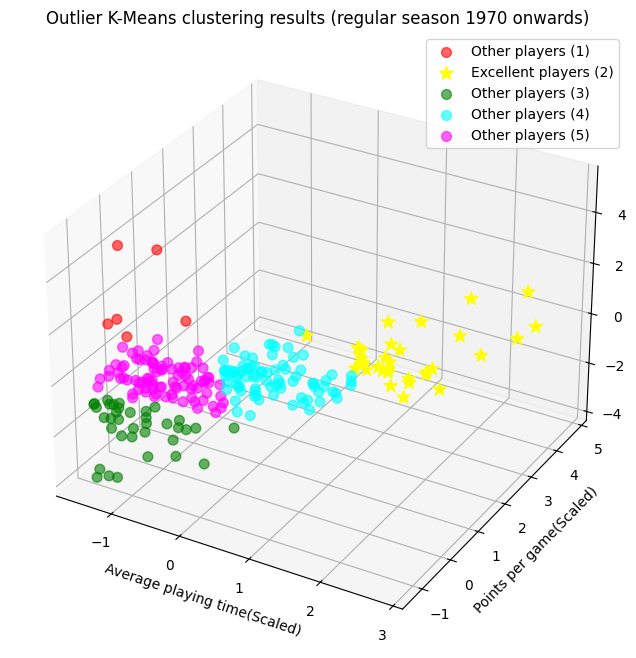

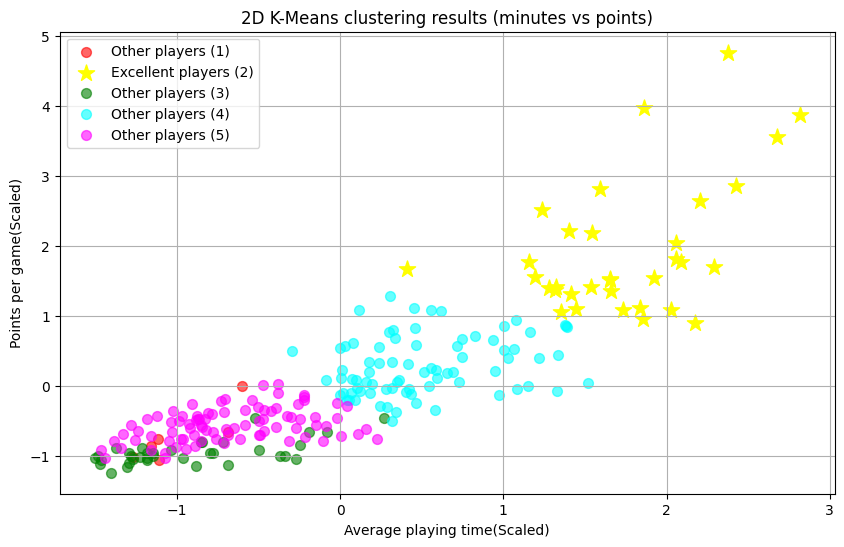

In [46]:
## Outstanding player detection: clustering visualization

# Get data for visualization
X = clustering_data['X']
y_kmeans = clustering_data['y_kmeans']
outstanding_group = clustering_data['outstanding_group']

# Color mapping
colors = ['red', 'blue', 'green', 'cyan', 'magenta']
# Cluster labels
labels = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']
feature_names = ['Average playing time(Scaled)', 'Points per game(Scaled)', 'Shooting percentage(Scaled)']

# Plot a 3D scatter
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster
for i in range(5):
    # Highlight the outstanding-player cluster
    if i == outstanding_group:
        ax.scatter(X[y_kmeans == i, 0], X[y_kmeans == i, 1], X[y_kmeans == i, 2],
                   s=100, c='yellow', label=f'Excellent players ({i+1})', marker='*', alpha=1)
    else:
        ax.scatter(X[y_kmeans == i, 0], X[y_kmeans == i, 1], X[y_kmeans == i, 2],
                   s=50, c=colors[i], label=f'Other players ({i+1})', alpha=0.6)

ax.set_title('Outlier K-Means clustering results (regular season 1970 onwards)')
ax.set_xlabel(feature_names[0])
ax.set_ylabel(feature_names[1])
ax.set_zlabel(feature_names[2])
ax.legend()
plt.show()

print()
print()
# Plot a 2D scatter (points per game vs minutes per game)
plt.figure(figsize=(10, 6))
for i in range(5):
    # Highlight the outstanding-player cluster
    if i == outstanding_group:
        plt.scatter(X[y_kmeans == i, 0], X[y_kmeans == i, 1],
                    s=150, c='yellow', label=f'Excellent players ({i+1})', marker='*', alpha=1)
    else:
        plt.scatter(X[y_kmeans == i, 0], X[y_kmeans == i, 1],
                    s=50, c=colors[i], label=f'Other players ({i+1})', alpha=0.6)

plt.title('2D K-Means clustering results (minutes vs points)')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.legend()
plt.grid(True)
plt.show()